e:\anaconda\envs\torch\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


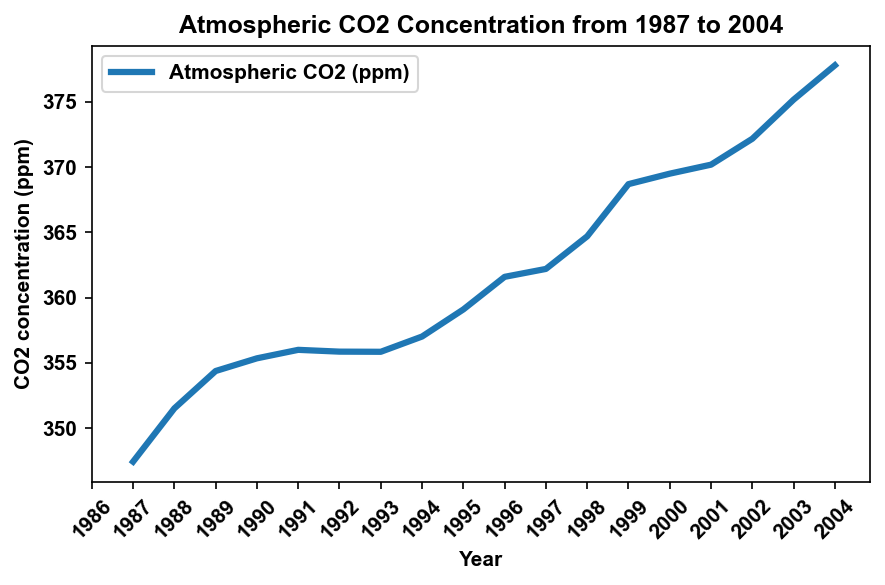

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint

# 设置字体样式和大小
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 10

# 加载CO2排放数据集
# Loading the CO2 emission dataset
co2_emissions = pd.read_excel('data/Global_Carbon_Budget_2016_v1.0.xlsx', sheet_name='Global Carbon Budget')
co2_emissions.columns = co2_emissions.iloc[20] # Using row 20 as headers
co2_emissions = co2_emissions.iloc[21:] # Skipping rows before the data starts
co2_emissions = co2_emissions[['Year', 'fossil fuel and cement emissions', 'land-use change emissions','ocean sink','land sink','atmospheric growth']]
co2_emissions = co2_emissions[(co2_emissions['Year'] >= 1987) & (co2_emissions['Year'] <= 2004)]
co2_emissions['total_emissions'] = co2_emissions['fossil fuel and cement emissions'] + co2_emissions['land-use change emissions'] - co2_emissions['ocean sink'] - co2_emissions['land sink']
yearly_emissions = dict(zip(co2_emissions['Year'], co2_emissions['total_emissions']))


# 模型的常数
k12 = 105/740  # 大气到海洋的转移系数
k21 = 102/900  # 海洋到大气的转移系数

# 1986年的初始值，单位为PgC
N1_initial = 740  # 大气中的碳含量
N2_initial = 900  # 海洋表面的碳含量

# 将PgC转换为ppm
N1_initial_ppm = N1_initial/2.13  # PgC到ppm的转换因子
N2_initial_ppm = N2_initial/2.13

# 模型的微分方程
def model_no_buffer(N, t, k12, k21, yearly_emissions):
    N1, N2 = N
    year = int(t)
    gamma = yearly_emissions.get(year, 0) # Default to 0 if year is not in the dataset
    dN1dt = -k12 * N1 + k21 * N2 + gamma
    dN2dt = k12 * N1 - k21 * N2
    return [dN1dt, dN2dt]


# 解决微分方程
years = np.arange(1987, 2005)
N0 = [N1_initial_ppm, N2_initial_ppm]
solution = odeint(model_no_buffer, N0, years, args=(k12, k21, yearly_emissions))

# 提取并转换N1为ppm
N1_ppm = solution[:, 0]

# 绘制结果
plt.figure(figsize=(6, 4), dpi=150)
plt.plot(years, N1_ppm, label="Atmospheric CO2 (ppm)", linewidth=3)

plt.xticks(np.arange(1986, 2005, 1), rotation=45)
plt.xlabel("Year", weight='bold')
plt.ylabel("CO2 concentration (ppm)", weight='bold')
plt.title("Atmospheric CO2 Concentration from 1987 to 2004",weight='bold')
plt.legend()
plt.tight_layout()
plt.show()

e:\anaconda\envs\torch\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


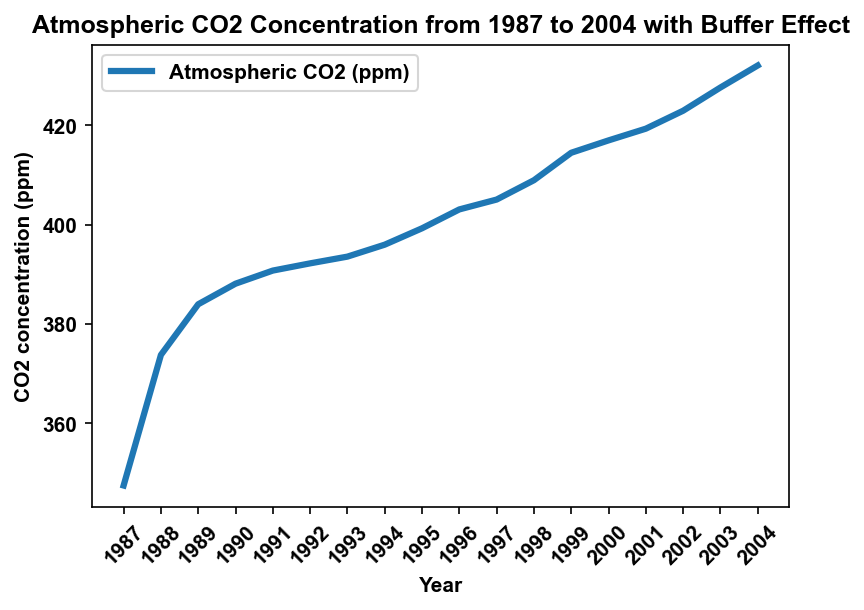

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint

co2_emissions = pd.read_excel('data/Global_Carbon_Budget_2016_v1.0.xlsx', sheet_name='Global Carbon Budget')
co2_emissions.columns = co2_emissions.iloc[20] # Using row 20 as headers
co2_emissions = co2_emissions.iloc[21:] # Skipping rows before the data starts
co2_emissions = co2_emissions[['Year', 'fossil fuel and cement emissions', 'land-use change emissions','ocean sink','land sink','atmospheric growth']]
co2_emissions = co2_emissions[(co2_emissions['Year'] >= 1987) & (co2_emissions['Year'] <= 2004)]
co2_emissions['total_emissions'] = co2_emissions['fossil fuel and cement emissions'] + co2_emissions['land-use change emissions'] - co2_emissions['ocean sink'] - co2_emissions['land sink']
yearly_emissions = dict(zip(co2_emissions['Year'], co2_emissions['total_emissions']))


# 模型的常数
k12 = 105/740  # 大气到海洋的转移系数
k21 = 102/900  # 海洋到大气的转移系数

# 1986年的初始值，单位为PgC
N1_initial = 740  # 大气中的碳含量
N2_initial = 900  # 海洋表面的碳含量

# 将PgC转换为ppm
N1_initial_ppm = N1_initial/2.13  # PgC到ppm的转换因子
N2_initial_ppm = N2_initial/2.13

# 计算缓冲因子的函数


def calculate_buffer_factor(z):
     
    return z*1.72208
# 对列表中的每个浓度值计算缓冲因子
buffer_factors = calculate_buffer_factor(co2_emissions['atmospheric growth'])


yearly_buffer_factors = dict(zip(co2_emissions['Year'], buffer_factors))
# 模型的微分方程，包含缓冲效应
def model_with_buffer(N, t, k12, k21, yearly_emissions):
    N1, N2 = N
    year = int(t)
    gamma = yearly_emissions.get(year, 0) # Default to 0 if year is not in the dataset
    dN1dt = -k12 * N1 + k21 * (821/2.13 + (3.69 + 1.86e-2 * N1 - 1.80e-6 * N1**2) * (N2-821/2.13)) + gamma
    dN2dt = k12 * N1 - k21 * (821/2.13 + (3.69 + 1.86e-2 * N1 - 1.80e-6 * N1**2) * (N2-821/2.13))
    return [dN1dt, dN2dt]

# 解决微分方程
years = np.arange(1987, 2005)
N0 = [N1_initial_ppm, N2_initial_ppm]
solution = odeint(model_with_buffer, N0, years, args=(k12, k21, yearly_emissions))

# 提取并转换N1为ppm
N1_ppm = solution[:, 0]

# 绘制结果
plt.figure(figsize=(6, 4), dpi=150)
plt.plot(years, N1_ppm, label="Atmospheric CO2 (ppm)", linewidth=3)
plt.xticks(np.arange(1987, 2005, 1), rotation=45)
plt.xlabel("Year", weight='bold')
plt.ylabel("CO2 concentration (ppm)", weight='bold')
plt.title("Atmospheric CO2 Concentration from 1987 to 2004 with Buffer Effect", weight='bold')
plt.legend()
plt.show()


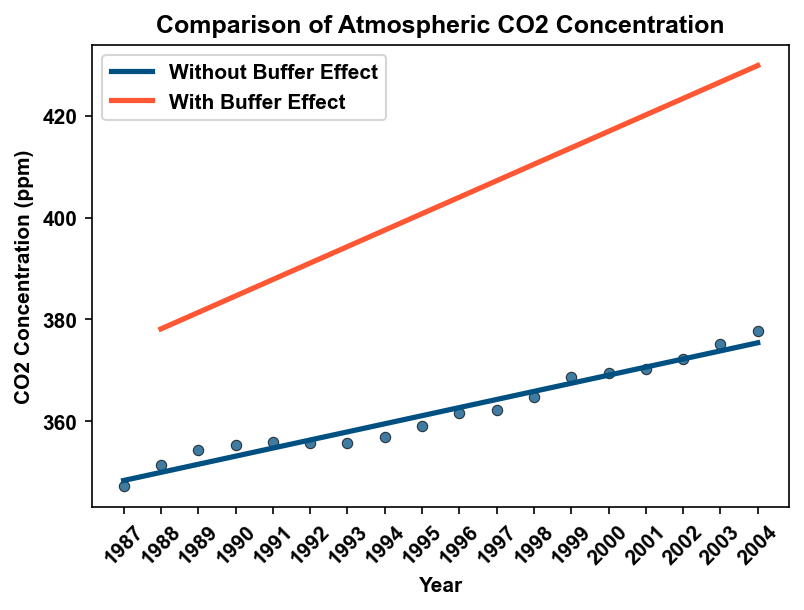

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

# 你之前定义的模型参数和函数
# ...

# 解决1.1问题的微分方程（不包含缓冲效应）
solution_no_buffer = odeint(model_no_buffer, N0, years, args=(k12, k21, yearly_emissions))

# 解决1.2问题的微分方程（包含缓冲效应）
solution_with_buffer = odeint(model_with_buffer, N0, years, args=(k12, k21, yearly_emissions))

# 提取并转换N1为ppm
N1_ppm_no_buffer = solution_no_buffer[:, 0]
N1_ppm_with_buffer = solution_with_buffer[:, 0]
# Fit linear regression line to the data
linear_regression_no_buffer = np.polyfit(years, N1_ppm_no_buffer, 1)
linear_regression_with_buffer = np.polyfit(years[1:], N1_ppm_with_buffer[1:], 1)

# Generate the linear regression line
linear_regression_line_no_buffer = np.polyval(linear_regression_no_buffer, years)

linear_regression_line_with_buffer = np.polyval(linear_regression_with_buffer, years[1:])


# Plot the data with linear regression lines
plt.figure(figsize=(6, 4), dpi=150)
plt.scatter(years, N1_ppm_no_buffer,  s=25,marker='o',linewidths=0.5,edgecolors='black',alpha=0.75,color='#005082')
# plt.scatter(years, N1_ppm_with_buffer, label="With Buffer Effect", s=50, marker='x')
plt.plot(years, linear_regression_line_no_buffer, label="Without Buffer Effect", linewidth=2.5, color='#005082')
plt.plot(years[1:], linear_regression_line_with_buffer, label="With Buffer Effect", linewidth=2.5, color='#FF5733')


plt.xticks(np.arange(1987, 2005, 1), rotation=45)
plt.xlabel("Year", weight='bold')
plt.ylabel("CO2 Concentration (ppm)", weight='bold')
plt.title("Comparison of Atmospheric CO2 Concentration", weight='bold')
plt.legend()
plt.show()



e:\anaconda\envs\torch\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


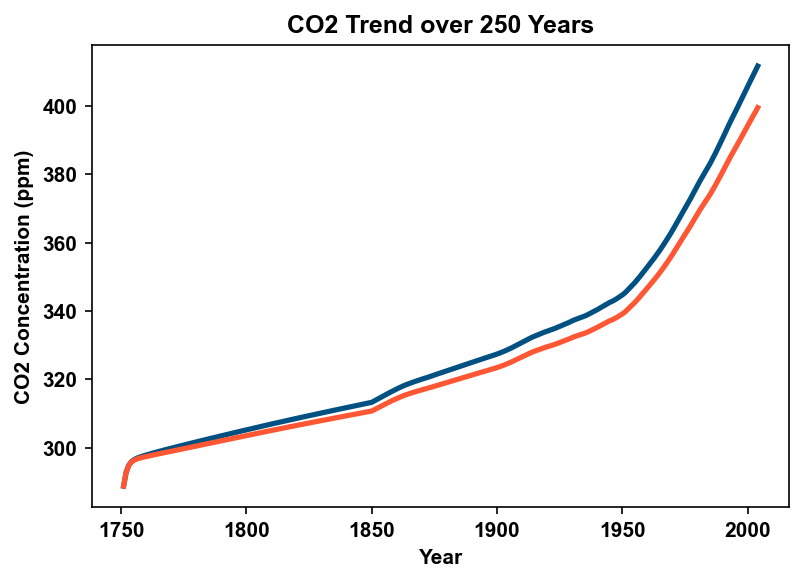

In [9]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#
co2_emissions = pd.read_csv('data/global.1751_2014.csv')
co2_emissions = co2_emissions.iloc[1:] # 从3行开始才是数据
co2_emissions = co2_emissions[['Year','Total carbon emissions from fossil fuel consumption and cement production (million metric tons of C)','Carbon emissions from cement production',]] #根据文中对γ的描述，选择fossil fuel一列
co2_emissions['Year']=co2_emissions['Year'].apply(lambda x: int(x)) #由于表格内数据都是str格式，这里统一修改为int
co2_emissions['Total carbon emissions from fossil fuel consumption and cement production (million metric tons of C)']=co2_emissions['Total carbon emissions from fossil fuel consumption and cement production (million metric tons of C)'].apply(lambda x: int(x))
co2_emissions['Carbon emissions from cement production']=co2_emissions['Carbon emissions from cement production'].apply(lambda x: int(x))
co2_emissions = co2_emissions[(co2_emissions['Year'] > 1750) & (co2_emissions['Year'] < 2005)]
co2_emissions['fossil_fuel_emissions'] = (co2_emissions['Total carbon emissions from fossil fuel consumption and cement production (million metric tons of C)'] - co2_emissions['Carbon emissions from cement production'])/(2.13*1000)
yearly_emissions = dict(zip(co2_emissions['Year'], co2_emissions['fossil_fuel_emissions'])) #创建年排放字典，通过zip添加映射

# 载入表格数据，并且根据表格里的具体解释选择相应列和年份
landusechange_emissions = pd.read_excel('data/Global_Carbon_Budget_2016_v1.0.xlsx', sheet_name='Historical Budget')
landusechange_emissions.columns = landusechange_emissions.iloc[13] #将第13行作为列名，挺奇怪的这表格
landusechange_emissions = landusechange_emissions.iloc[14:] # Skipping rows before the data starts
landusechange_emissions = landusechange_emissions[['Year', 'land-use change emissions']]
landusechange_emissions = landusechange_emissions[(landusechange_emissions['Year'] >1750) & (landusechange_emissions['Year'] <=2004)]
landusechange_emissions['land-use change emissions'] = landusechange_emissions['land-use change emissions']/2.13

land_use_change = dict(zip(landusechange_emissions['Year'], landusechange_emissions['land-use change emissions']))
landusechange_emissions.columns = landusechange_emissions.iloc[13]

#定义初始值并把单位转化为ppm
N1_0= 615/2.13 
N2_0 = 842/2.13 
N3_0 = 9744/2.13 
N4_0 = 26280/2.13 
N5_0 = 90000000/2.13
N6_0 = 731/2.13
N7_0 = 1328/2.13

#定义模型系数
k12 = 60/615
k21 = 60/842 
k23 = 9/842
k24 = 43/842
k32 = 52/9744
k34 = 162/9744
k43 = 205/26280
k45 = 0.2/26280
k51 = 0.2/90000000
k67 = 62/731
k71 = 62/1328


# 定义微分方程
def model1_3(N, t, k12, k21, k23, k24, k32, k34, k43, k45, k51, k67, k71, β, yearly_emissions, land_use_change):
    N1, N2, N3, N4, N5, N6, N7= N
    year = int(t)
    N20 = 821/2.13
    f0 = 62/2.13
    P0 = 290.21
    f = f0 * (1 + β * np.log(N1/P0))
    gamma = yearly_emissions.get(year, 0)
    delta = land_use_change.get(year, 0)
    dN1dt = -k12 * N1 + k21 * (N20 +(3.69 + 1.86e-2 * N1 - 1.80e-6 * N1**2) * (N2 - N20)) + gamma - f + delta + k51 * N5 + k71 * N7 
    dN2dt = k12 * N1 - k21 * (N20 +(3.69 + 1.86e-2 * N1 - 1.80e-6 * N1**2) * (N2 - N20)) - k23 * N2 + k32 * N3 - k24 * N2
    dN3dt = k23 * N2 - k32 * N3 - k34 * N3 + k43 * N4
    dN4dt = k34 * N3 - k43 * N4 + k24 * N2 - k45 * N4
    dN5dt = k45 * N4 - k51 * N5
    dN6dt = f - k67 * N6 - 2 * delta
    dN7dt = k67 * N6 - k71 * N7 + delta
    return [dN1dt, dN2dt, dN3dt, dN4dt, dN5dt, dN6dt, dN7dt]

# Solving the differential equations
years = np.arange(1751, 2005)
N0 = [N1_0, N2_0, N3_0, N4_0, N5_0, N6_0, N7_0]
β= 0.38
β1 = 0.5
solution1_3 = odeint(model1_3, N0, years, args=(k12, k21, k23, k24, k32, k34, k43, k45, k51, k67, k71, β, yearly_emissions, land_use_change))
solution1_3_1 = odeint(model1_3, N0, years, args=(k12, k21, k23, k24, k32, k34, k43, k45, k51, k67, k71, β1, yearly_emissions, land_use_change))
# 提取结果
N1_PPM_1_3 = solution1_3[:, 0]
N1_PPM_1_3_1 = solution1_3_1[:, 0]
# 画图
plt.figure(figsize=(6, 4), dpi=150)
plt.plot(years, N1_PPM_1_3, linewidth=2.5,color='#005082')
plt.plot(years, N1_PPM_1_3_1, linewidth=2.5, color='#FF5733')
plt.title("CO2 Trend over 250 Years", weight='bold')
plt.xlabel("Year", weight='bold')
plt.ylabel("CO2 Concentration (ppm)", weight='bold')
plt.show()

